In [1]:
import numpy as np 
import jVMC
import jax.numpy as jnp
import jax.random as jrnd
import matplotlib.pyplot as plt
from tqdm import tqdm
import optax
import h5py as h5
import time
def re_grad(grad,renormalisation):
    if renormalisation is not None:
        if renormalisation < 0:
            renormalisation = np.min([-renormalisation, np.linalg.norm(grad)])
        grad = renormalisation *grad/np.linalg.norm(grad)
    return grad
def adam_update(psi,psiSampler,H,stateAdam,optAdam,renormalisation=None):
    psi_s, psi_logPsi, psi_p = psiSampler.sample()

    Eloc = H.get_O_loc(psi_s, psi, psi_logPsi)
    Eso = jVMC.util.SampledObs(Eloc, psi_p)
    Emean = Eso.mean()[0]
    Evar = Eso.var()[0]
    Opsi = psi.gradients(psi_s)
    grads = jVMC.util.SampledObs(Opsi, psi_p)
    Egrad = 2.*grads.covar(Eso)
    grad = jnp.real(Egrad)
    grad = jnp.nan_to_num(grad,0.)
    n_grad = np.linalg.norm(grad)

    grad = re_grad(grad,renormalisation)

    psi_params = psi.get_parameters()
    n_p = jnp.linalg.norm(psi_params)

    upAdam, stateAdam = optAdam.update(
        grad.reshape(psi_params.shape), stateAdam, psi_params  # type: ignore
    )
    
    params = optax.apply_updates(psi_params, upAdam)  # type: ignore
    
    psi.set_parameters(params)
    return Emean.real,Evar,stateAdam,n_p, n_grad

def sr_update_old(  psi,stepperSR,equations,H,):
    dpOld = psi.get_parameters()
    n_p = jnp.linalg.norm(dpOld)
    p_new, _ = stepperSR.step(0, equations, dpOld, hamiltonian=H, psi=psi)
    n_grad = jnp.linalg.norm(p_new-dpOld)
    psi.set_parameters(jnp.real(p_new))
    return  jnp.real(equations.ElocMean0) , equations.ElocVar0, n_p, n_grad# n_grad rescaled!

def sr_update(psi,lr_SR,equations,H,renormalisation=None,repeats=10):
    dpOld = psi.get_parameters()            
    n_p = jnp.linalg.norm(dpOld)
    dp    = equations(dpOld,0,hamiltonian=H, psi=psi,intStep=0)
    dp = jnp.nan_to_num(dp,0.)
    #for i in range(repeats):
    #    dp_add  = equations(dpOld,0,hamiltonian=H, psi=psi,intStep=0)
    #    dp += jnp.nan_to_num(dp_add,0.)
    #dp /= repeats
    n_grad = jnp.linalg.norm(dp)

    dp = re_grad(dp,renormalisation)

    #dp, _ = stepperSR.step(0, equations, dpOld, hamiltonian=H, psi=psi)
    psi.set_parameters(dpOld + lr_SR * jnp.real(dp))
    return  jnp.real(equations.ElocMean0) , equations.ElocVar0, n_p, n_grad




In [2]:


folder = ""#"/Data/pgi-8/steinhuber/git/vmc_jax/myStuff/runs/sep2024/data/"

L = 20
N = L
ldim = N+1
homFock = jnp.ones((1,1,L),dtype=int)
oneSiteFockStates = jnp.expand_dims(jnp.eye(L,dtype=int)*N,0)
J = 1.
U = 1.

name = f"N{N}_L{L}_ldim{ldim}_J{J:.3f}_U{U:.3f}"
H = jVMC.operator.bosons.BoseHubbard_Hamiltonian1D(L,J,U,lDim=ldim)

depth_RWKV = 5
emb_RWKV = 10
hidden_size = 32
num_heads = 2

nameRWKV = folder + "RWKV_" +name+ f"_netpara_dep{depth_RWKV}_emb{emb_RWKV}_hid{hidden_size}_nH{num_heads}"

ebDim = 16
dep = 3
nH = 4
nameGPT = folder + "GPT_" + name+f"_netpara_dep{dep}_emb{ebDim}_nH{nH}"

netRWKV = jVMC.nets.RpxRWKV(L,LocalHilDim=ldim,hidden_size=hidden_size,num_heads=num_heads,embedding_size=emb_RWKV,num_layers=depth_RWKV,)
netGPT = jVMC.nets.bosons.gpt_stupid.GPT(L,ldim,embeddingDim=ebDim,depth=dep,nHeads=nH)
seed = 252
key2 = jrnd.PRNGKey(seed)

par_netRWKV = jVMC.nets.particle_conservation(netRWKV,N)
par_netGPT = jVMC.nets.particle_conservation(netGPT,N)


sym= jVMC.util.symmetries.get_orbit_1D(L,"reflection","translation")
sym_par_netRWKV = jVMC.nets.sym_wrapper.SymNet(sym,par_netRWKV,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)
sym_par_netGPT = jVMC.nets.sym_wrapper.SymNet(sym,par_netGPT,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)

batSize = min([1024,int(2**12 //(2**np.ceil(np.log(L)/np.log(2))))])
batSize = np.max([batSize,2])
print("batchsize set to", batSize)
psi_RWKV= jVMC.vqs.NQS(sym_par_netRWKV,seed=seed,batchSize=batSize)
psi_GPT= jVMC.vqs.NQS(sym_par_netGPT,seed=seed,batchSize=batSize)

key = jrnd.PRNGKey(1)
key2 = jrnd.PRNGKey(1)
sampler_RWKV = jVMC.sampler.MCSampler(psi_RWKV,(L,),key2)
sampler_GPT = jVMC.sampler.MCSampler(psi_GPT,(L,),key2)

print("parameters gpt:",len(psi_GPT.get_parameters()),"parameters RWKV",len(psi_RWKV.get_parameters()))


batchsize set to 128
parameters gpt: 10341 parameters RWKV 12062


In [3]:
h5saveGPT = jVMC.util.h5SaveParams(nameGPT.replace('.','-')+".hdf5",'r')
h5saveRWKV = jVMC.util.h5SaveParams(nameRWKV.replace('.','-')+".hdf5",'r')


In [4]:
f = h5saveRWKV.open()
training_keys = [int(a.replace("training_step_","")) for a in f.keys() if "training_step_" in a]
h5saveRWKV.close(f)
parameterRWKV = h5saveRWKV.load_model_params(None,f"training_step_{np.max(training_keys)}") 
print("before: homogeneous fockstate probability:", psi_RWKV(homFock))
psi_RWKV.params = parameterRWKV["params"]
print("after setting parameters: homogeneous fockstate probability:", psi_RWKV(homFock))
print(323)

before: homogeneous fockstate probability: [[-17.85227846]]
after setting parameters: homogeneous fockstate probability: [[-6.17363924]]
323


In [5]:
f = h5saveGPT.open()
training_keys = [int(a.replace("training_step_","")) for a in f.keys() if "training_step_" in a]
h5saveGPT.close(f)
parameterGPT = h5saveGPT.load_model_params(None,f"training_step_{np.max(training_keys)}") 
parameterGPT["params"]
print("before: homogeneous fockstate probability:", psi_GPT(homFock))
psi_GPT.params = parameterGPT["params"]
print("after setting parameters: homogeneous fockstate probability:", psi_GPT(homFock))


before: homogeneous fockstate probability: [[-57.15510632]]
after setting parameters: homogeneous fockstate probability: [[-6.14711301]]


In [6]:
U_cal = 2.
H = jVMC.operator.bosons.BoseHubbard_Hamiltonian1D(L,J,U_cal,lDim=ldim)

folder_cal = ""
name_cal = f"N{N}_L{L}_ldim{ldim}_J{J:.3f}_U{U_cal:.3f}"
nameRWKV_cal = folder_cal + "RWKV_" +name_cal+ f"_netpara_dep{depth_RWKV}_emb{emb_RWKV}_hid{hidden_size}_nH{num_heads}"

nameGPT_cal = folder_cal + "GPT_" + name_cal+f"_netpara_dep{dep}_emb{ebDim}_nH{nH}"


h5saveGPT = jVMC.util.h5SaveParams(nameGPT_cal.replace('.','-')+".hdf5",'w')
h5saveRWKV = jVMC.util.h5SaveParams(nameRWKV_cal.replace('.','-')+".hdf5",'w')

In [7]:
diagonalShift = 1e-4
diagonalMulti = 1e-4
lr_SR = 1e-2
numSamp = 2**8
sampler_GPT.numSamples = numSamp
sampler_GPT.numSamples = numSamp

minSR_equationRWKV = jVMC.util.MinSR(sampler_RWKV, makeReal='real',diagonalShift=diagonalShift,diagonalMulti=diagonalMulti)
minSR_equationGPT = jVMC.util.MinSR(sampler_GPT, makeReal='real',diagonalShift=diagonalShift,diagonalMulti=diagonalMulti)



In [8]:
training_steps= 1350
resTrainingRWKV = np.zeros((training_steps,5))
resTrainingGPT = np.zeros((training_steps,5))

windowADAM = np.zeros(training_steps,dtype=bool)

windowADAM[:150] = True

windowADAM[450:600] = True

windowADAM[900:1050] = True
print(windowADAM)



[ True  True  True ... False False False]


In [9]:

pbar = tqdm(range(training_steps))

lr_ADAM = 0.01


optAdam_GPT = optax.inject_hyperparams(optax.adamax)(learning_rate=lr_ADAM)
stateAdam_GPT = optAdam_GPT.init(psi_GPT.get_parameters()) 
minSR_equation_GPT = jVMC.util.MinSR(sampler_GPT, makeReal='real',diagonalShift=diagonalShift,diagonalMulti=diagonalMulti,pinvTol=1e-14)

optAdam_RWKV = optax.inject_hyperparams(optax.adamax)(learning_rate=lr_ADAM)
stateAdam_RWKV = optAdam_RWKV.init(psi_RWKV.get_parameters()) 
minSR_equation_RWKV = jVMC.util.MinSR(sampler_RWKV, makeReal='real',diagonalShift=diagonalShift,diagonalMulti=diagonalMulti,pinvTol=1e-14)

renormalisation = None
for n,p in enumerate(pbar):
    if windowADAM[n]:
        pbar.set_description("adam training")
    else:
        pbar.set_description("SR training")

    ticGPT = time.perf_counter()
    if windowADAM[n]:
        Emean,Evar,stateAdam_GPT,n_p,n_p_grad = adam_update(psi_GPT,sampler_GPT,H,stateAdam_GPT,optAdam_GPT,renormalisation=renormalisation)
    else:
        #Emean,Evar = sr_update_old(psi,stepperSR,minSR_equation,H)
        Emean,Evar,n_p,n_p_grad  = sr_update(psi_GPT,lr_SR,minSR_equation_GPT,H,renormalisation=renormalisation)
    tocGPT = time.perf_counter()
    #print(Emean,Evar)
    resTrainingGPT[n] = [Emean,Evar,n_p,n_p_grad,tocGPT-ticGPT]
    #progressRange.set_postfix(energy=f"{Emean:.2f}", variance = f" {Evar:.2e}", norm_p=f"{n_p:.2f}",norm_p_grad=f"{n_p_grad:.2f}")
    ticRWKV = time.perf_counter()
    if windowADAM[n]:
        Emean,Evar,stateAdam_RWKV,n_p,n_p_grad = adam_update(psi_RWKV,sampler_RWKV,H,stateAdam_RWKV,optAdam_RWKV,renormalisation=renormalisation)
    else:
        #Emean,Evar = sr_update_old(psi,stepperSR,minSR_equation,H)
        Emean,Evar,n_p,n_p_grad  = sr_update(psi_RWKV,lr_SR,minSR_equation_RWKV,H,renormalisation=renormalisation)
    tocRWKV = time.perf_counter()
    resTrainingRWKV[n] = [Emean,Evar,n_p,n_p_grad,tocRWKV-ticRWKV]

    h5saveRWKV.save_model_params(psi_RWKV.parameters,
                                            f"training_step_{n}",
                                            {"Emean" :resTrainingRWKV[n,0],
                                             "Evar" :resTrainingRWKV[n,1],
                                             "norm_parameter" :resTrainingRWKV[n,2],
                                             "norm_gradient" :resTrainingRWKV[n,3],
                                             "time" : tocRWKV-ticRWKV
                                             })
    h5saveGPT.save_model_params(psi_GPT.parameters,
                                            f"training_step_{n}",
                                            {"Emean" :resTrainingGPT[n,0],
                                             "Evar" :resTrainingGPT[n,1],
                                             "norm_parameter" :resTrainingGPT[n,2],
                                             "norm_gradient" :resTrainingGPT[n,3],
                                             "time" : tocGPT-ticGPT
                                            })
                                            #{"infidelity": infidelities[i],
                                            #"time":T,
                                            #"psi_obs":psi_obs,
                                            #"psi_var":psi_var,
                                            #"chi_obs":chi_obs,
                                            #"chi_var":chi_var,
                                            #"lr":learning_rate,
                                            #"dshift":d_shift,
                                            #"seed":seed,
                                            #"numSamples":numSamples,
                                            #"net_size":psi_params.shape[0],
                                            #"net":config["net"]})
    postfix = {"E_GPT": resTrainingGPT[n,0], 
               "E_RWKV": resTrainingRWKV[n,0], 
               "var E_GPT": resTrainingGPT[n,1], 
               "var E_RWKV": resTrainingRWKV[n,1], 
               }
    pbar.set_postfix(postfix)


  0%|          | 0/1350 [00:00<?, ?it/s]

SR training:  28%|██▊       | 372/1350 [05:05<13:23,  1.22it/s, E_GPT=0, E_RWKV=-26.8, var E_GPT=0, var E_RWKV=0.22]             


KeyboardInterrupt: 

In [10]:
h5saveGPT.save_model_params({"mean" : resTrainingGPT[:,0], "var" : resTrainingGPT[:,1]},"energy_training",{})
h5saveGPT.save_model_params({"norm" : resTrainingGPT[:,2], "grad norm" : resTrainingGPT[:,3]},"norm_parameter",{})
#h5saveGPT.save_model_params({"total_time" : resTrainingGPT[:,4]},"timing",{})
h5saveGPT.save_model_params({"adam" : windowADAM},"training",{"default": "SR", "lr_SR" : lr_SR,"lr_ADAM" : lr_ADAM})

h5saveRWKV.save_model_params({"mean" : resTrainingRWKV[:,0], "var" : resTrainingRWKV[:,1]},"energy_training",{})
h5saveRWKV.save_model_params({"norm" : resTrainingRWKV[:,2], "grad norm" : resTrainingRWKV[:,3]},"norm_parameter",{})
#h5saveRWKV.save_model_params({"total_time" : resTrainingRWKV[:,4]},"timing",{})
h5saveRWKV.save_model_params({"adam" : windowADAM},"training",{"default": "SR", "lr_SR" : lr_SR,"lr_ADAM" : lr_ADAM})


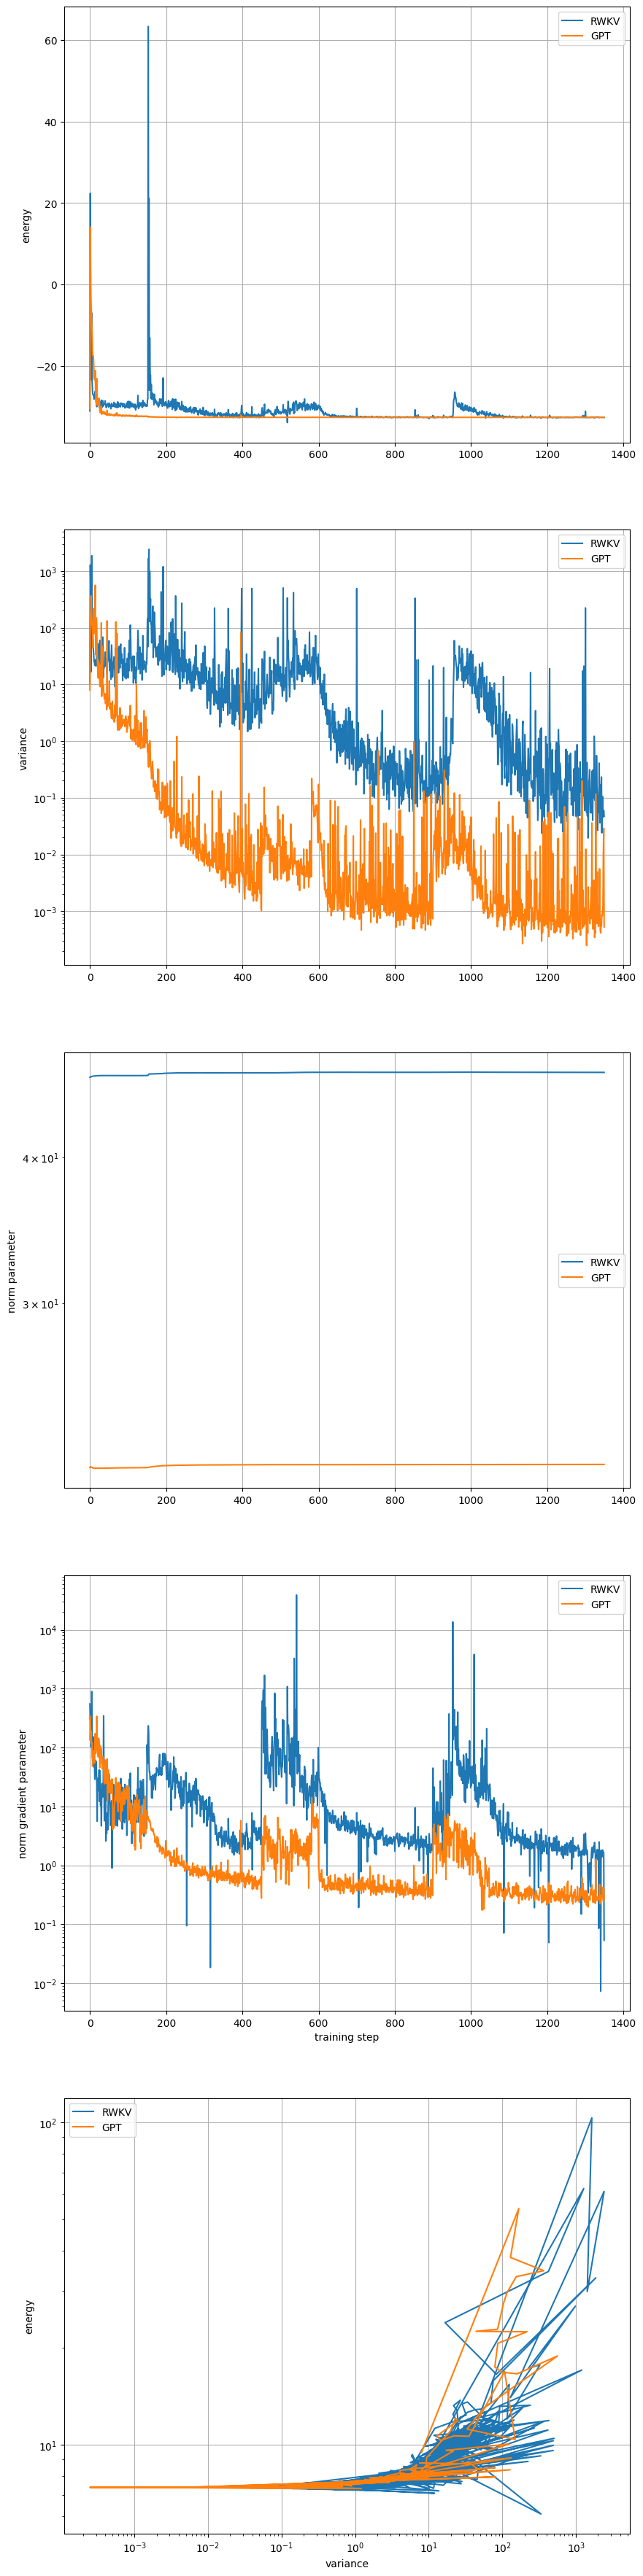

In [11]:


# %%
fig,ax = plt.subplots(5,figsize=(10,45))
ax[0].plot(resTrainingRWKV[:,0],label="RWKV")
ax[0].plot(resTrainingGPT[:,0],label="GPT")
ax[0].set_ylabel("energy")
ax[0].legend()
ax[0].grid()
ax[1].plot(resTrainingRWKV[:,1],label="RWKV")
ax[1].semilogy(resTrainingGPT[:,1],label="GPT")
ax[1].set_ylabel("variance")
ax[1].legend()
ax[1].grid()
ax[2].plot(resTrainingRWKV[:,2],label="RWKV")
ax[2].semilogy(resTrainingGPT[:,2],label="GPT")
ax[2].set_ylabel("norm parameter")
ax[2].grid()
ax[2].legend()
ax[3].plot(resTrainingRWKV[:,3],label="RWKV")
ax[3].semilogy(resTrainingGPT[:,3],label="GPT")
ax[3].set_xlabel("training step")
ax[3].grid()
ax[3].set_ylabel("norm gradient parameter")

ax[3].legend()

emin = -2*J*N
ax[4].loglog(resTrainingRWKV[:,1],np.abs(emin-resTrainingRWKV[:,0]),label="RWKV")
ax[4].loglog(resTrainingGPT[:,1],np.abs(emin-resTrainingGPT[:,0]),label="GPT")
ax[4].legend()
ax[4].set_ylabel("energy")
ax[4].set_xlabel("variance")
ax[4].grid()


nameFIG = folder_cal + "plot_difference_" +name
nameFIG += f"_RWKVpara_dep{depth_RWKV}_emb{emb_RWKV}_hid{hidden_size}_nH{num_heads}"

nameFIG += f"_GPTpara_dep{dep}_emb{ebDim}_nH{nH}"
plt.savefig(nameFIG+".pdf")
